# Analysing ESG report using Natural Language Processing
by Chee-Foong on 12 Mar 2021, updated by Jingjie Yeo on 15 Jul 2021


## Summary
Environment, Social and Corporate Governance (ESG) refers to the three central factors in measuring the sustainability and societal impact of an investment in a company or business.  These criteria help to better determin the future financial performance of companies (return and risk).

This analysis extracts text from a ESG report in PDF format from the internet, performs NLP on these information, summaries the key ESG initiatives with WordClouds, TDIDFs and discovers topics by building a Latent Dirichlet Allocation (LDA) model.

To keep this exercise as simple as possible, only one ESG report is being used.  Specifically the [Citibank's 2019 ESG report](https://www.citigroup.com/citi/about/esg/download/2019/Global-ESG-Report-2019.pdf?ieNocache=967).  

Given that ESG is a broad topic.  Different companies focus on different aspects of ESG depending on their business operations and culture.  One can potentially ingest more ESG reports from different companies across all sectors and industries to capture relevant ESG topics.  This to be attempted in another analysis.



## Reference

1. [A data-driven approach to Environmental, Social and Governance](https://databricks.com/blog/2020/07/10/a-data-driven-approach-to-environmental-social-and-governance.html)
2. [Higher ESG ratings are generally positively correlated with valuation and profitability while negatively correlated with volatility.](https://corpgov.law.harvard.edu/2020/01/14/esg-matters/)
3. [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
4. [Citibank's 2019 ESG report](https://www.citigroup.com/citi/about/esg/download/2019/Global-ESG-Report-2019.pdf?ieNocache=967)
5. [Databricks - ESG Reports](https://databricks.com/notebooks/esg_notebooks/01_esg_report.html)
5. [Databricks - Data Driven ESG Score](https://databricks.com/notebooks/esg_notebooks/02_esg_scoring.html)
6. [Databricks - ESG Market Risk](https://databricks.com/notebooks/esg_notebooks/03_esg_market.html)
7. [Topic Modeling and Latent Dirichlet Allocation (LDA) in Python](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)
8. [Evaluate Topic Models: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)
9. [Topic modeling visualization – How to present the results of LDA models?](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)



## Install Dependencies

In [1]:
# !pip install PyPDF2
# !pip install gensim
# !pip install nltk
# !pip install WordCloud
# !pip install pdfminer3
# !pip install mlflow
# !pip3 install spacy
# !pip3 install pyLDAvis==2.1.2
# !pip install yfinance

In [2]:
# !pip freeze

---
## Import Libraries

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import pandas as pd
import numpy as np

# pd.options.display.max_columns = 50
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 50)

plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

In [4]:
import sys  
sys.path.append('../src') 
from edge import *

In [5]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

# PDF text extraction
from pdfminer.layout import LAParams, LTTextBox
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
from pdfminer.converter import TextConverter

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Others
import requests
import io
import string
import re
from pprint import pprint
from tqdm.notebook import tqdm
import io
import urllib3

Create Folders

In [6]:
DATA_FOLDER = '../data/'
PDF_FOLDER = '../pdf/'
createfolder(DATA_FOLDER)
createfolder(PDF_FOLDER)

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Loading Language Model

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /Users/Angela/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Angela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Preparing Stop Words

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
', '.join(stop_words)

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"him, becomes, although, many, not, fifty, ie, hereafter, don't, find, anything, whose, system, no, t, bill, hers, d, meanwhile, few, yourselves, wouldn't, forty, if, during, seems, anywhere, show, off, having, cannot, here, hereupon, should, hasnt, part, move, she's, mine, on, whence, well, nine, did, it, haven't, three, been, seeming, two, wasn't, what, third, interest, or, top, you've, rather, etc, you'll, whither, after, mightn't, ever, hereby, must, former, while, wouldn, re, nothing, cry, into, much, also, then, myself, even, moreover, where, give, which, alone, aren't, it's, less, other, behind, she, un, below, onto, there, yet, per, serious, when, mustn't, six, you're, via, now, beside, just, another, everything, seemed, ll, since, doesn't, have, whom, hasn, doesn, almost, m, may, eight, being, us, herein, again, twenty, already, you'd, next, doing, neither, everywhere, this, ours, thence, across, fire, do, those, somewhere, whereby, am, something, thereupon, still, twelve, unt

## Report Details

Enter required information about the report.  Report must be in PDF format and downloadable from a URL.

1. Company Name
2. Company Ticker Symbol
3. Year of the Report
4. URL of the Report

In [10]:
report_company = 'citibank'
report_ticker = 'C'
report_year = '2019'
report_url = 'https://www.citigroup.com/citi/about/esg/download/2019/Global-ESG-Report-2019.pdf?ieNocache=979'

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Additional information - ESG Score from Yahoo Finance

In [11]:
import yfinance as yf

ticker_info = yf.Ticker(report_ticker)
esg_data = pd.DataFrame(ticker_info.sustainability)
esg_data.columns = [str(ticker_info.ticker)]

esg_data.loc[['totalEsg','socialScore','governanceScore','environmentScore',
              'esgPerformance','percentile','peerGroup','highestControversy'],:]

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,C
2021-5,
totalEsg,26.34
socialScore,11.43
governanceScore,13.43
environmentScore,1.47
esgPerformance,AVG_PERF
percentile,44.53
peerGroup,Banks
highestControversy,4


## Text Extraction
Extract information from the PDF report.  This process may take some time.  Do be patient.

*You may skip to the last step of this section if you have previously extracted the contents and stored in a json file.*

In [12]:
def extract_pdf(file, verbose=False):
    
    if verbose:
        print('Processing {}'.format(file))

    try:
        resource_manager = PDFResourceManager()
        fake_file_handle = io.StringIO()
        laparams = LAParams()

        converter = TextConverter(resource_manager, fake_file_handle, laparams=laparams)
        page_interpreter = PDFPageInterpreter(resource_manager, converter)
        
        password = ""
        maxpages = 0
        pagenos = set()

        content = []

        for page in PDFPage.get_pages(file,
                                      pagenos, 
                                      maxpages=maxpages,
                                      password=password,
                                      caching=True,
                                      check_extractable=False):

            page_interpreter.process_page(page)

            content.append(fake_file_handle.getvalue())

            fake_file_handle.truncate(0)
            fake_file_handle.seek(0)        

        text = '##PAGE_BREAK##'.join(content)

        # close open handles
        converter.close()
        fake_file_handle.close()
        
        return text

    except Exception as e:
        print(e)

        # close open handles
        converter.close()
        fake_file_handle.close()

        return ""

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def extract_content(url):
    """
    A simple user define function that, given a url, download PDF text content
    Parse PDF and return plain text version
    """
    headers={"User-Agent":"Mozilla/5.0"}

    try:
        # retrieve PDF binary stream
        r = requests.get(url, allow_redirects=True, headers=headers)
        
        # access pdf content
        text = extract_pdf(io.BytesIO(r.content))

        # return concatenated content
        return text

    except:
        return ""

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
report_content = extract_content(report_url)

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Storing all information in a json file

In [15]:
import json

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
report = {'company':report_company, 'year':report_year, 'ticker':report_ticker, 
          'url':report_url, 'content':report_content}

with open(DATA_FOLDER + report_company + report_year + '.json', "w") as outfile:  
    json.dump(report, outfile)

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reloading the json file when required

In [17]:
with open(DATA_FOLDER + report_company + report_year + '.json') as inputfile:
     report = json.load(inputfile)

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---

## Natural Language Processing

### Extracting content by pages and sentences

1. Only properly structured sentences are extracted.  Sentences that start with a Capital Letter and ends with a period.  Sentences that are less than 10 words or more than 50 words are ignored.  
2. Pages with less than 500 words are excluded from extraction.  Would like to focus on pages with mostly text content.  This should exclude pages like cover and last page.  It should also exclude pages that are more graphical with short notes and comments.

In [18]:
def remove_non_ascii(text):
    printable = set(string.printable)
    return ''.join(filter(lambda x: x in printable, text))

def not_header(line):
    # as we're consolidating broken lines into paragraphs, we want to make sure not to include headers
    return not line.isupper()

def extract_sentences(nlp, text):
    """
    Extracting ESG statements from raw text by removing junk, URLs, etc.
    We group consecutive lines into paragraphs and use spacy to parse sentences.
    """
    MIN_WORDS_PER_PAGE = 500
    
    pages = text.split('##PAGE_BREAK##')
#     print('Number of Pages: {}'.format(len(pages)))

    lines = []
    for page in pages:
        
        # remove non ASCII characters
        text = remove_non_ascii(page)
        
        if len(text.split(' ')) < MIN_WORDS_PER_PAGE:
#             print('Skipped Page: {}'.format(len(text.split(' '))))
            continue
        
        prev = ""
        for line in text.split('\n\n'):
            # aggregate consecutive lines where text may be broken down
            # only if next line starts with a space or previous does not end with dot.
            if(line.startswith(' ') or not prev.endswith('.')):
                prev = prev + ' ' + line
            else:
                # new paragraph
                lines.append(prev)
                prev = line

        # don't forget left-over paragraph
        lines.append(prev)
        lines.append('##SAME_PAGE##')
        
    lines = '  '.join(lines).split('##SAME_PAGE##')
    
    # clean paragraphs from extra space, unwanted characters, urls, etc.
    # best effort clean up, consider a more versatile cleaner
    
    sentences = []
    pages_content = []

    for line in lines[:-1]:
        # removing header number
        line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
        # removing trailing spaces
        line = line.strip()
        # words may be split between lines, ensure we link them back together
        line = re.sub(r'\s?-\s?', '-', line)
        # remove space prior to punctuation
        line = re.sub(r'\s?([,:;\.])', r'\1', line)
        # ESG contains a lot of figures that are not relevant to grammatical structure
        line = re.sub(r'\d{5,}', r' ', line)
        # remove emails
        line = re.sub(r'\S*@\S*\s?', '', line)
        # remove mentions of URLs
        line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
        # remove multiple spaces
        line = re.sub(r'\s+', ' ', line)
        # join next line with space
        line = re.sub(r' \n', ' ', line)
        line = re.sub(r'.\n', '. ', line)
        line = re.sub(r'\x0c', ' ', line)
        
        pages_content.append(str(line).strip())

        # split paragraphs into well defined sentences using spacy
        for part in list(nlp(line).sents):
            sentences.append(str(part).strip())

#           sentences += nltk.sent_tokenize(line)
            
    # Only interested in full sentences and sentences with 10 to 100 words.
    sentences = [s for s in sentences if re.match('^[A-Z][^?!.]*[?.!]$', s) is not None]
    sentences = [s.replace('\n', ' ') for s in sentences]
    sentences = [s for s in sentences if (len(s.split(' ')) > 10) & (len(s.split(' ')) < 100)]

    return pages_content, sentences

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
report_pages, report_sentences = extract_sentences(nlp, report['content'])

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


On best effort basis, excluding header and footer contents that are not relevant.

In [20]:
headers = ['Contents Our Approach to ESG Solutions for Impact How We Do Business Appendices', 'Citi 2019 ESG Report']

for header in headers:
    report_pages = [p.replace(header, "").strip() for p in report_pages]
    report_sentences = [p.replace(header, "").strip() for p in report_sentences]    

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenization, Bigrams and Lemmatization

In [21]:
def run_NLP(content):

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    data_words = list(sent_to_words(content))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    return data_lemmatized

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using full text content in a page rather than full text content in a sentence here.  A page defined as a document as per TFIDF calculation.  

In [22]:
data_lemmatized = run_NLP(report_pages)

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
report_sentences_lemma = [' '.join(w) for w in data_lemmatized]

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
import random
report_sentences_lemma[random.randint(0, len(report_sentences_lemma))]

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'exist customer example use biometric make credit card loan application process efficient customer technology enable automatic income verification remote confirmation client identity use facial customer quick secure digital option opening account branch nationwide case technology reduce wait time customer contribute positive customer satisfaction increase integration digital tech nologie process increase accessibility product service unable visit branch develop solution serve institutional client embrac ing mobile technology citidirect digital solution institutional customer enable secure convenient way authorize payment view balance cash position manage user expand access client country caribbean enable use fingerprint facial recognition access platform design partnership client biometric solution enable authentication mere second serve alternative method secure access account introduce app biometric authentication capability additional market region develop solution customer feedback

Relevant sentences are now well defined for ESG corpus.

### Word Cloud - Corpus Wide Term Frequencies

In [25]:
# context specific keywords not to include in topic modelling
fsi_stop_words = [
  'plc', 'group', 'target',
  'track', 'capital', 'holding',
  'report', 'annualreport',
  'esg', 'bank', 'report',
  'annualreport', 'long', 'make'
]

fsi_stop_words.append(report_company)
fsi_stop_words.append('citi')

# our list contains all english stop words + companies names + specific keywords
stop_words = stop_words.union(fsi_stop_words)

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


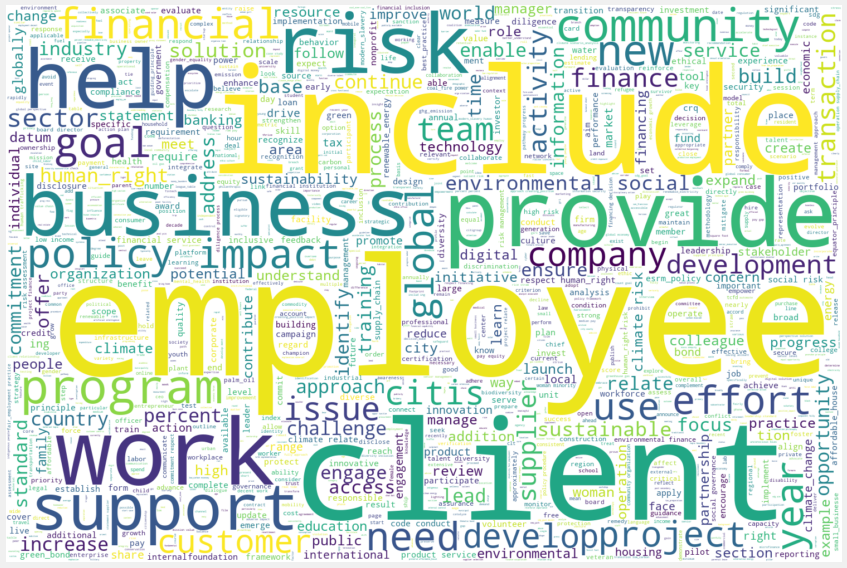

In [26]:
from wordcloud import WordCloud

# aggregate all 7200 records into one large string to run wordcloud on term frequency
large_string = ' '.join(report_sentences_lemma)

# use 3rd party lib to compute term freq., apply stop words
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=1500, 
    height=1000, 
    stopwords=stop_words, 
    contour_width=3, 
    contour_color='steelblue'
)

# display our wordcloud across all records
plt.figure(figsize=(16,16))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### TFIDF - Unigram and Bigram Analysis

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


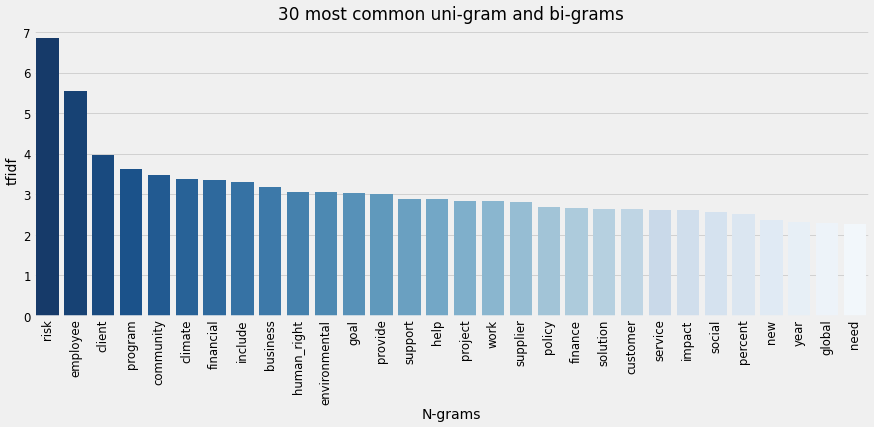

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Run bi-gram TF-IDF frequencies
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=10, use_idf=True)
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(report_sentences_lemma)

# Extract bi-grams names
words = bigram_tf_idf_vectorizer.get_feature_names()

# extract our top 10 ngrams
total_counts = np.zeros(len(words))
for t in bigram_tf_idf:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 

# Plot top 10 ngrams
plt.figure(figsize=(16, 6))
plt.subplot(title='30 most common uni-gram and bi-grams')
sns.barplot(x_pos, counts, palette='Blues_r')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('N-grams')
plt.ylabel('tfidf')
plt.show()

---


## Topic Modeling and Latent Dirichlet Allocation (LDA)

Evaluaton Metrics
1. **Perplexity**: Captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.  Lower the better.
2. **Coherence Score**: Measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.  Higher the better.

In the analysis, the model with the highest coherence score is selected as the optimal model.

In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
results = []
optimal_score = 0
optimal_model = None

for num_of_topics in tqdm(range(2,15,1)):
    
    result = {}
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_of_topics, 
                                                random_state=42,
                                                update_every=1,
                                                chunksize=5,
                                                passes=20,
                                                alpha='auto',
                                                per_word_topics=True) 

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    if optimal_score < coherence_model_lda.get_coherence():
        optimal_score = coherence_model_lda.get_coherence()
        optimal_model = lda_model

    result['num_of_topics'] = num_of_topics
    result['perplexity'] = lda_model.log_perplexity(corpus)
    result['coherence_score'] = coherence_model_lda.get_coherence()
    
    results.append(result)
    
results = pd.DataFrame(results)  
results.set_index('num_of_topics', inplace=True) 

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/13 [00:00<?, ?it/s]

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


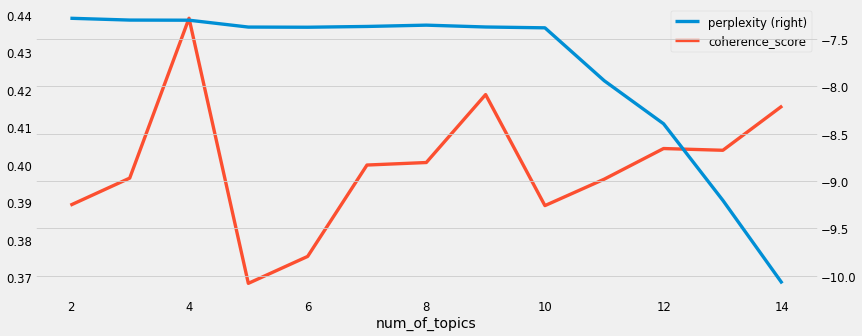

In [30]:
results.plot(secondary_y='perplexity')
plt.show()

In [31]:
results

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,perplexity,coherence_score
num_of_topics,,
2,-7.281898,0.389247
3,-7.301021,0.396480
4,-7.302352,0.439112
5,-7.374915,0.368406
6,-7.376672,0.375591
7,-7.368409,0.399964
8,-7.354652,0.400635
9,-7.374092,0.418755
10,-7.382910,0.389142


In [32]:
# Compute Perplexity
print('\nPerplexity of the Optimal Model: ', optimal_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score of the Optimal Model: ', coherence_lda)


Perplexity of the Optimal Model:  -7.30235226867584


/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score of the Optimal Model:  0.43911217453633594


---

## Visualize the topics

In [33]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.040778  0.218498       1        1  45.721678
3     -0.026412 -0.011448       2        1  25.096582
1     -0.154476 -0.144901       3        1  21.630253
2      0.221666 -0.062149       4        1   7.551486, topic_info=               Term        Freq       Total Category  logprob  loglift
363            risk  150.000000  150.000000  Default  30.0000  30.0000
280        employee  215.000000  215.000000  Default  29.0000  29.0000
75    environmental   76.000000   76.000000  Default  28.0000  28.0000
868         percent   57.000000   57.000000  Default  27.0000  27.0000
657     human_right   58.000000   58.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
849            hire    6.157968   10.942926   Topic4  -5.4235   2.0085
1115          equal    6.701789   13.996846   Topic4  -5.3389   1.8470
928       education    6.808386   16.022693   Topic4  -5.3231   1.7276
91             goal    8.114494   66.190498   Topic4  -5.1476   0.4845
139            make    5.382358   32.032757   Topic4  -5.5582   0.7998

[229 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1         1  0.977164     access
2         1  0.259912   activity
2         2  0.590709   activity
2         3  0.141770   activity
1933      3  0.902959     adhere
...     ...       ...        ...
230       3  0.211768       work
1446      1  0.967591  workforce
1967      3  0.906791  workplace
233       1  0.838921       year
233       2  0.147179       year

[278 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [34]:
# Print the Keyword in the 10 topics
pprint(optimal_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"citi" + 0.016*"employee" + 0.013*"program" + 0.011*"provide" + '
  '0.011*"help" + 0.009*"support" + 0.009*"work" + 0.009*"new" + '
  '0.009*"customer" + 0.009*"business"'),
 (1,
  '0.020*"employee" + 0.018*"citi" + 0.015*"risk" + 0.014*"human_right" + '
  '0.013*"supplier" + 0.013*"policy" + 0.012*"respect" + 0.010*"diversity" + '
  '0.010*"conduct" + 0.009*"include"'),
 (2,
  '0.022*"pay" + 0.021*"woman" + 0.015*"percent" + 0.012*"compensation" + '
  '0.010*"representation" + 0.008*"level" + 0.008*"family" + 0.008*"minority" '
  '+ 0.006*"parent" + 0.006*"goal"'),
 (3,
  '0.019*"risk" + 0.016*"client" + 0.016*"environmental" + 0.014*"report" + '
  '0.012*"social" + 0.012*"project" + 0.012*"impact" + 0.009*"transaction" + '
  '0.009*"climate" + 0.008*"goal"')]


/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---

## Distinguishing the different ESG topics

In [35]:
topic_names = {0: 'support community', 1: 'value employees'}

#     'value employees',
#     'ethical investments',
#     'strong governance',
#     'focus customer',    
#     'green energy',
#     'support community',
#     'code of conduct',
#     'sustainable finance',
#     'company transformation',


/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


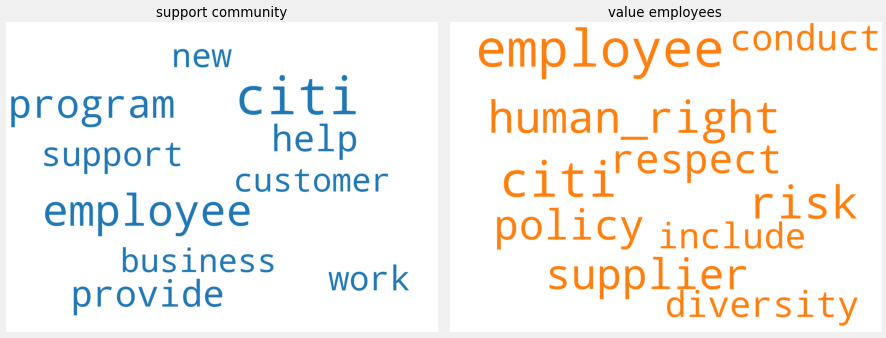

In [36]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Closing Notes
1. This is only a simple analysis that studies the ESG topics in only one ESG report.  This study can be extended to more reports issued by the many companies across different sectors and industries.
2. We can expect the number of topics to increase when more ESG reports are included in the study.
3. Once relevant ESG topics are identified, then we can potentially calculate ESG scores by topics for all companies.  Then we can assess and see whether such ESG score derived through NLP process correlates with the score given by rating agencies downloaded from yahoo finance.